Data is from https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection

## Data Preprocessing

### Loading the data and initial exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('data/fraud_oracle.csv')
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


Variable types:

In [3]:
df.dtypes.sort_values()

PolicyNumber             int64
RepNumber                int64
Year                     int64
FraudFound_P             int64
Age                      int64
Deductible               int64
WeekOfMonthClaimed       int64
DriverRating             int64
WeekOfMonth              int64
PoliceReportFiled       object
AgentType               object
NumberOfSuppliments     object
AgeOfVehicle            object
PastNumberOfClaims      object
Days_Policy_Claim       object
Days_Policy_Accident    object
AddressChange_Claim     object
NumberOfCars            object
WitnessPresent          object
AgeOfPolicyHolder       object
Month                   object
VehicleCategory         object
PolicyType              object
Fault                   object
MaritalStatus           object
Sex                     object
MonthClaimed            object
DayOfWeekClaimed        object
AccidentArea            object
Make                    object
DayOfWeek               object
VehiclePrice            object
BasePoli

Some variables should be numeric based on their name, but is indicated as object here, such as `NumberofCars`. Let's see the data:

In [4]:
df['NumberOfCars'].unique()

array(['3 to 4', '1 vehicle', '2 vehicles', '5 to 8', 'more than 8'],
      dtype=object)

As you can see it contains strings. We will convert these strings to number soon.

Number of unique values in each variable:

In [5]:
df.nunique().sort_values()

WitnessPresent              2
AgentType                   2
FraudFound_P                2
AccidentArea                2
PoliceReportFiled           2
Fault                       2
Sex                         2
Year                        3
BasePolicy                  3
VehicleCategory             3
PastNumberOfClaims          4
Days_Policy_Claim           4
DriverRating                4
Deductible                  4
MaritalStatus               4
NumberOfSuppliments         4
NumberOfCars                5
WeekOfMonthClaimed          5
Days_Policy_Accident        5
AddressChange_Claim         5
WeekOfMonth                 5
VehiclePrice                6
DayOfWeek                   7
DayOfWeekClaimed            8
AgeOfVehicle                8
PolicyType                  9
AgeOfPolicyHolder           9
Month                      12
MonthClaimed               13
RepNumber                  16
Make                       19
Age                        66
PolicyNumber            15420
dtype: int

Notice: `MonthClaimed` has 13 unique values instead of 12.

In [6]:
df['MonthClaimed'].unique()

array(['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May',
       'Jun', 'Sep', 'Oct', '0'], dtype=object)

Turns out there are rows with `'0'` as month. How many are they?

In [7]:
df[df['MonthClaimed']=='0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


So there's only one row. We will fix this soon.

Let's see the unique values in categorical variables that contain numbers:

In [8]:
num_cat_vars = [
    'NumberOfSuppliments',
    'AgeOfVehicle',
    'PastNumberOfClaims',
    'Days_Policy_Claim',
    'Days_Policy_Accident',
    'NumberOfCars',
    'AgeOfPolicyHolder',
    'VehiclePrice',
]

for var in num_cat_vars:
    print(var, df[var].unique())

NumberOfSuppliments ['none' 'more than 5' '3 to 5' '1 to 2']
AgeOfVehicle ['3 years' '6 years' '7 years' 'more than 7' '5 years' 'new' '4 years'
 '2 years']
PastNumberOfClaims ['none' '1' '2 to 4' 'more than 4']
Days_Policy_Claim ['more than 30' '15 to 30' '8 to 15' 'none']
Days_Policy_Accident ['more than 30' '15 to 30' 'none' '1 to 7' '8 to 15']
NumberOfCars ['3 to 4' '1 vehicle' '2 vehicles' '5 to 8' 'more than 8']
AgeOfPolicyHolder ['26 to 30' '31 to 35' '41 to 50' '51 to 65' '21 to 25' '36 to 40'
 '16 to 17' 'over 65' '18 to 20']
VehiclePrice ['more than 69000' '20000 to 29000' '30000 to 39000' 'less than 20000'
 '40000 to 59000' '60000 to 69000']


I notice large occurences of `'none'` in `PastNumberClaims` and `NumberOfSuppliments`:

In [9]:
(df=='none').mean().sort_values().tail(10)

WeekOfMonthClaimed      0.000000
Sex                     0.000000
MaritalStatus           0.000000
Age                     0.000000
Fault                   0.000000
BasePolicy              0.000000
Days_Policy_Claim       0.000065
Days_Policy_Accident    0.003567
PastNumberOfClaims      0.282231
NumberOfSuppliments     0.457004
dtype: float64

I'm going to assume that in those columns `'none'` actually means zero.

### Data preprocessing

Here's what I will do:

- Drop `PolicyNumber` column because it's just an ID number (DONE)
- Convert `'none'` values to NaN (DONE)
- Fix `MonthClaimed` column as stated before (DONE)
- Convert categorical columns that use numbers, like `WeekOfMonth` and `WeekOfMonthClaimed` (DONE)
- Convert ordinal columns to have ordinal data type (DONE)
- Create numerical columns from categorical columns that contain number ranges (like `NumberOfCars`) (DONE)
- Convert `none` in `PastNumberOfClaims` and `NumberOfSuppliments` columns to zero

In [10]:
def parse_numerical_range(series: pd.Series, addl_map: dict=dict()) -> pd.Series:
    '''
    Convert str column containing numerical range.
    Conversion rules:
    - "a" -> a
    - "less than a" -> a
    - "a to b" -> (a + b) / 2
    - "greater than b" -> b
    - "over b" -> b
    - NA -> NA
    '''
    unique_values = series.dropna().unique()
    conversion_map = {}
    for val in unique_values:
        if ' to ' in val:
            num_re = re.search(r'(\d+) to (\d+)', val)
            lbound = float(num_re.group(1))
            ubound = float(num_re.group(2))
            conversion_map[val] = (lbound + ubound) / 2
        else:
            num_re = re.search(r'(\d+)', val)
            if num_re:
                conversion_map[val] = float(num_re.group(1))

    conversion_map = {**conversion_map, **addl_map}
    series = series.replace(conversion_map)
    return series

In [11]:
df_proc = df.copy()
df_proc = df_proc.drop('PolicyNumber', axis=1)

# convert categorical columns that use numbers
cat_num_vars = [
    'WeekOfMonthClaimed',
    'DriverRating',
    'WeekOfMonth',
    'RepNumber',
]
for var in cat_num_vars:
    df_proc[var] = pd.Categorical(df_proc[var])

# convert 'none' to None
df_proc = df_proc.replace('none', np.nan)

# replace '0' in MonthClaimed
df_proc['MonthClaimed'] = df_proc['MonthClaimed'].replace('0', np.nan)

# replace none in these 2 columns with 0
df_proc[['PastNumberOfClaims', 'NumberOfSuppliments']] = df_proc[['PastNumberOfClaims', 'NumberOfSuppliments']].fillna('0')

# convert column with number ranges to numerical
for var in num_cat_vars:
    new_var = f'{var}_Num'

    if var == 'AgeOfVehicle':
        addl_map={'new': 0.0, 'more than 7': 8.0}
        # df_proc[new_var] = df_proc[new_var].replace()
    else:
        addl_map = {}
    
    df_proc[new_var] = parse_numerical_range(df_proc[var], addl_map).astype(float)

    categories = df_proc.sort_values(new_var)[var].dropna().unique()
    df_proc[var] = pd.Categorical(df_proc[var], categories=categories, ordered=True)

# create datetime column
df_proc['MonthYear'] = pd.to_datetime(df_proc['Month'] + ' ' + df_proc['Year'].astype(str), format='%b %Y')

Let's see the resulting data types:

In [12]:
df_proc.dtypes.astype(str).sort_values()

Days_Policy_Claim                 category
WeekOfMonth                       category
NumberOfCars                      category
NumberOfSuppliments               category
AgeOfPolicyHolder                 category
AgeOfVehicle                      category
PastNumberOfClaims                category
WeekOfMonthClaimed                category
Days_Policy_Accident              category
DriverRating                      category
RepNumber                         category
VehiclePrice                      category
MonthYear                   datetime64[ns]
AgeOfPolicyHolder_Num              float64
NumberOfCars_Num                   float64
Days_Policy_Accident_Num           float64
VehiclePrice_Num                   float64
Days_Policy_Claim_Num              float64
PastNumberOfClaims_Num             float64
AgeOfVehicle_Num                   float64
NumberOfSuppliments_Num            float64
FraudFound_P                         int64
Age                                  int64
Deductible 

In [13]:
df_proc.nunique().sort_values()

Sex                          2
Fault                        2
PoliceReportFiled            2
AccidentArea                 2
FraudFound_P                 2
AgentType                    2
WitnessPresent               2
VehicleCategory              3
Days_Policy_Claim            3
Year                         3
BasePolicy                   3
Days_Policy_Claim_Num        3
PastNumberOfClaims           4
Days_Policy_Accident         4
NumberOfSuppliments_Num      4
DriverRating                 4
NumberOfSuppliments          4
Deductible                   4
PastNumberOfClaims_Num       4
Days_Policy_Accident_Num     4
MaritalStatus                4
WeekOfMonth                  5
NumberOfCars                 5
AddressChange_Claim          5
WeekOfMonthClaimed           5
NumberOfCars_Num             5
VehiclePrice_Num             6
VehiclePrice                 6
DayOfWeek                    7
AgeOfVehicle_Num             8
DayOfWeekClaimed             8
AgeOfVehicle                 8
AgeOfPol

### Handling missing values

How common do missing values occur now?

In [14]:
df_proc.isna().mean().sort_values().tail(6)

DayOfWeek                   0.000000
Days_Policy_Claim           0.000065
Days_Policy_Claim_Num       0.000065
MonthClaimed                0.000065
Days_Policy_Accident_Num    0.003567
Days_Policy_Accident        0.003567
dtype: float64

In [15]:
df_proc.isna().any(axis=1).mean()

0.0036316472114137485

It only occurs 0.36% of the time. **I'm going to drop them.**

In [16]:
df_proc_dropna = df_proc.dropna(how='any')
df_proc_dropna.shape

(15364, 41)

## Invalid age data?

There are some data with age equals to zero:

In [17]:
(df_proc['Age']==0).mean()

0.020752269779507133

It occurs 2% of the time. I will ignore it and treat them as is.

### Train-test-split

In [18]:
df_train, df_non_train = train_test_split(
    df_proc_dropna, train_size=0.8, random_state=99,
    stratify=df_proc_dropna['FraudFound_P']
)
df_valid, df_test = train_test_split(
    df_non_train, train_size=0.5, random_state=52,
    stratify=df_non_train['FraudFound_P']
)

print('df_train', df_train.shape)
print('df_valid', df_valid.shape)
print('df_test', df_test.shape)

df_train (12291, 41)
df_valid (1536, 41)
df_test (1537, 41)


## Question 1

Determine the percentage of claims identified as fraudulent based on fraud indicators in the dataset (e.g., using the column FraudFound_P). This includes calculating: 

- The total number of claims
- The number of claims flagged as fraudulent (where FraudFound_P == 1)
- The proportion of fraudulent claims is expressed as a percentage.


Here I will use the full data after the NANs have been dropped.

In [19]:
print('Total number of claims:', len(df_proc_dropna))
print('Number of fraudulent claims:', df_proc_dropna['FraudFound_P'].sum())
print(f'Percentage of fraudulent claims: {df_proc_dropna['FraudFound_P'].mean() * 100:.2f}%')

Total number of claims: 15364
Number of fraudulent claims: 914
Percentage of fraudulent claims: 5.95%


## Question 2 (descriptive statistics)

One of the analyses needed is to compare the characteristics of fraudulent and normal insurance claims to derive insights that can help the insurance company understand the nature of these claims better.

- Numerical variables
    - Variables (5 total): Age, WeekofMonth, etc 
[Add up to five additional variables that could enhance insights into claims behavior]
    - Statistical Measures: Mean, Median, std, Min, and Max
- Categorical variables
    - Variables (5  total): VehiclePrice, Make, Fault, Days_Policy_Accident, etc [Add up to five additional variables that could enhance insights into claims behavior)
    - Statistical Measures: frequency and proportion

Comparative Analysis: Perform all the analysis above in three segments:

- Fraudulent Claims Only
- Normal Claims Only
- Combined View of Both Claims


### 2.1 Numerical variables

In [20]:
num_vars = [
    'AgeOfPolicyHolder_Num',
    'NumberOfCars_Num',
    'Days_Policy_Accident_Num',
    'VehiclePrice_Num',
    'Days_Policy_Claim_Num',
    'PastNumberOfClaims_Num',
    'AgeOfVehicle_Num',
    'NumberOfSuppliments_Num',
    'Age',
    'Deductible',
]

In [21]:
import scipy.stats as stats

To make the analysis faster, I will calculate the t-test for the difference in mean between fraud and non-fraud in each numerical variable.

In [22]:
is_fraud = df_train['FraudFound_P'] == 1
ttest_result_list = {}
for var in num_vars:
    group1 = df_train[is_fraud][var].dropna()
    group2 = df_train[~is_fraud][var].dropna()
    ttest = stats.ttest_ind(group1, group2, equal_var=True)
    ttest_result_list[var] = {
        'pvalue': ttest.pvalue,
        'statistic': ttest.statistic,
    }
ttest_result = pd.DataFrame(ttest_result_list).T.sort_values('pvalue')
ttest_result

,pvalue,statistic
PastNumberOfClaims_Num,1.565112e-10,-6.404354
VehiclePrice_Num,1.002979e-05,4.418373
AgeOfVehicle_Num,4.030732e-05,-4.107203
NumberOfSuppliments_Num,1.086945e-04,-3.871574
Age,2.933963e-04,-3.622102
AgeOfPolicyHolder_Num,7.375302e-04,-3.376085
Deductible,9.471061e-02,1.671185
NumberOfCars_Num,9.310578e-01,-0.086516
Days_Policy_Claim_Num,9.385139e-01,-0.077139
Days_Policy_Accident_Num,9.721981e-01,-0.034852


Which variables have p-value less than 1%?

In [23]:
ttest_result[ttest_result['pvalue'] < 0.01]

,pvalue,statistic
PastNumberOfClaims_Num,1.565112e-10,-6.404354
VehiclePrice_Num,1.002979e-05,4.418373
AgeOfVehicle_Num,4.030732e-05,-4.107203
NumberOfSuppliments_Num,1.086945e-04,-3.871574
Age,2.933963e-04,-3.622102
AgeOfPolicyHolder_Num,7.375302e-04,-3.376085


Based on the table above, we can make these preliminary conclusions: fraudulent claims are more likely to have more expensive cars, younger vehicle age, lower number of suppliments, lower number of past claims, younger policy holder's age, and younger driver's age (because those variables have t-test p-value less than 1%).

Let's see some statistics in each numerical variable for fraudulent and non-fraudulent claims:

In [24]:
df_proc.groupby('FraudFound_P')[num_vars].agg(['mean', 'std', 'median', 'min', 'max']).T

FraudFound_P                                0             1
AgeOfPolicyHolder_Num    mean       39.356867     38.233478
                         std         9.648038      9.817833
                         median     38.000000     38.000000
                         min        16.500000     16.500000
                         max        65.000000     65.000000
NumberOfCars_Num         mean        1.113644      1.131094
                         std         0.478967      0.508749
                         median      1.000000      1.000000
                         min         1.000000      1.000000
                         max         8.000000      6.500000
Days_Policy_Accident_Num mean       29.888727     29.845733
                         std         1.399680      1.666054
                         median     30.000000     30.000000
                         min         4.000000      4.000000
                         max        30.000000     30.000000
VehiclePrice_Num         mean    33541.111954  36018.959913
                         std     15501.732299  17952.649766
                         median  24500.000000  24500.000000
                         min     20000.000000  20000.000000
                         max     69000.000000  69000.000000
Days_Policy_Claim_Num    mean       29.951159     29.891116
                         std         0.785274      1.211526
                         median     30.000000     30.000000
                         min        11.500000     11.500000
                         max        30.000000     30.000000
PastNumberOfClaims_Num   mean        1.841209      1.490791
                         std         1.485686      1.437291
                         median      1.000000      1.000000
                         min         0.000000      0.000000
                         max         4.000000      4.000000
AgeOfVehicle_Num         mean        6.593985      6.386782
                         std         1.490593      1.648939
                         median      7.000000      7.000000
                         min         0.000000      0.000000
                         max         8.000000      8.000000
NumberOfSuppliments_Num  mean        2.037318      1.735103
                         std         2.159326      2.084438
                         median      1.500000      0.000000
                         min         0.000000      0.000000
                         max         5.000000      5.000000
Age                      mean       39.956957     38.265439
                         std        13.462013     13.871426
                         median     38.000000     36.000000
                         min         0.000000      0.000000
                         max        80.000000     80.000000
Deductible               mean      407.511899    410.725894
                         std        43.770260     46.619027
                         median    400.000000    400.000000
                         min       300.000000    300.000000
                         max       700.000000    700.000000

The result above confirms the t-test results. For example, the mean of `PastNumberOfClaims_Num` for fraudulent cases is 1.49, but 1.84 for non-fraudulent cases.

Now let's see the stats without considering the fraud vs non-fraud:

In [25]:
df_train[num_vars].agg(['mean', 'std', 'median', 'min', 'max']).T

,mean,std,median,min,max
AgeOfPolicyHolder_Num,39.281425,9.687676,38.0,16.5,65.0
NumberOfCars_Num,1.112277,0.473724,1.0,1.0,8.0
Days_Policy_Accident_Num,29.880075,1.460484,30.0,4.0,30.0
VehiclePrice_Num,33747.823611,15745.968602,24500.0,20000.0,69000.0
Days_Policy_Claim_Num,29.960866,0.688578,30.0,11.5,30.0
PastNumberOfClaims_Num,1.826784,1.487464,1.0,0.0,4.0
AgeOfVehicle_Num,6.580343,1.507384,7.0,0.0,8.0
NumberOfSuppliments_Num,2.019242,2.154257,1.5,0.0,5.0
Age,39.829306,13.507434,38.0,0.0,80.0
Deductible,407.859409,44.612773,400.0,300.0,700.0


### 2.2 Categorical variables

Since there are too many categorical variables, I will select the ones that have high Cramer's V coefficients (which is a correlation metric between 2 categorical variables).

In [26]:
def cramers_v(series1: pd.Series, series2: pd.Series) -> float:
    # Create a contingency table
    contingency_table = pd.crosstab(series1, series2)
    
    # Compute chi2 statistic
    chi2, _, _, _ = stats.chi2_contingency(contingency_table)
    
    # Compute Cramér's V
    n = contingency_table.sum().sum()  # Total number of observations
    k = min(contingency_table.shape)   # Min of num rows or columns
    v = np.sqrt(chi2 / (n * (k - 1)))
    
    return v

In [27]:
cat_vars = df_train.columns[(df_train.dtypes == 'category') | (df_train.dtypes == 'object')]
cat_vars

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'RepNumber', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
       'BasePolicy'],
      dtype='object')

I will calculate [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r's_V) (a correlation measure between two categorical variables) for each independent categorical variable, and use 10 variables with the highest Cramer's V for the next analysis.

In [28]:
cramers_vs = df_train[cat_vars].apply(lambda col: cramers_v(col, df_train['FraudFound_P']), axis=0)
cramers_vs = cramers_vs.sort_values(ascending=False)
chosen_catvars = cramers_vs.head(10).index
cramers_vs[chosen_catvars]

PolicyType             0.167043
BasePolicy             0.159731
VehicleCategory        0.136502
Fault                  0.130966
AddressChange_Claim    0.083717
VehiclePrice           0.064689
PastNumberOfClaims     0.060772
Make                   0.055757
MonthClaimed           0.051651
AgeOfPolicyHolder      0.045323
dtype: float64

<Axes: >

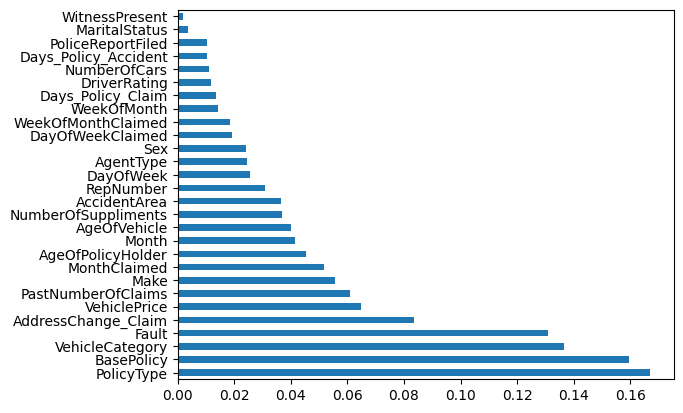

In [29]:
cramers_vs.plot.barh()

From the above, we can see variables that are related with vehicle & policy are correlated with fraud: PolicyType, BasePolicy, VehicleCategory, and Fault.

Now let's create cross tabs for each chosen categorical variables.

In [30]:
def binary_crosstab(x: pd.Series, y: pd.Series) -> pd.DataFrame:
    output = pd.crosstab(x, y, margins=True)
    props = pd.crosstab(x, y, normalize='index', margins=True)[1]
    output['P(y=1)'] = props
    return output

In [31]:
for var in chosen_catvars:
    print(var)
    print(binary_crosstab(df_train[var], df_train['FraudFound_P']).sort_values('P(y=1)'))
    print('---')

PolicyType
FraudFound_P              0    1    All    P(y=1)
PolicyType                                       
Sport - All Perils       17    0     17  0.000000
Sport - Liability         1    0      1  0.000000
Utility - Liability      18    0     18  0.000000
Sedan - Liability      3987   32   4019  0.007962
All                   11560  731  12291  0.059474
Sedan - Collision      4112  302   4414  0.068419
Sedan - All Perils     2933  323   3256  0.099201
Utility - All Perils    234   33    267  0.123596
Utility - Collision      19    3     22  0.136364
Sport - Collision       239   38    277  0.137184
---
BasePolicy
FraudFound_P      0    1    All    P(y=1)
BasePolicy                               
Liability      4006   32   4038  0.007925
All           11560  731  12291  0.059474
Collision      4370  343   4713  0.072777
All Perils     3184  356   3540  0.100565
---
VehicleCategory
FraudFound_P         0    1    All    P(y=1)
VehicleCategory                             
Sport       

From the above we can see several characteristics with high (>10%) fraud occurences, which is higher than the fraud occurence for the overall data (5.95%):

- PolicyType
    - Utility - All Perils
    - Utility - Collision
    - Sport - Collision
- BasePolicy
    - All Perils
- VehicleCategory
    - Utility
- AddressChange_Claim
    - 2 to 3 years
    - under 6 months
- Make
    - Saturn
    - Saab
    - Accura
- AgeOfPolicyHolder
    - 16 to 17
    - 21 to 25
    - 18 to 20

I will use some of the results above later when creating expert-based model.

## Question 3 (EDA visualizations)

Perform exploratory data analyses, Using the vehicle insurance claims dataset: 

- Create up to two visualizations to examine the distribution of numerical variables that are relevant for analyzing fraudulent cases. Use the fraudulent status as the hue to differentiate the distributions. What insights can you draw from your analysis regarding fraud detection?
- Create up to two time series visualizations to analyze trends over time. Use fraudulent status as the hue to differentiate the patterns. What trends or anomalies do you observe over time in relation to fraud detection?
- Create up to five visualizations to compare categorical variables. Provide insights from your analysis using these charts to understand fraudulent detection patterns.


### Numerical variables

Age distribution between fraud and non-fraud:

<Axes: xlabel='Age', ylabel='Density'>

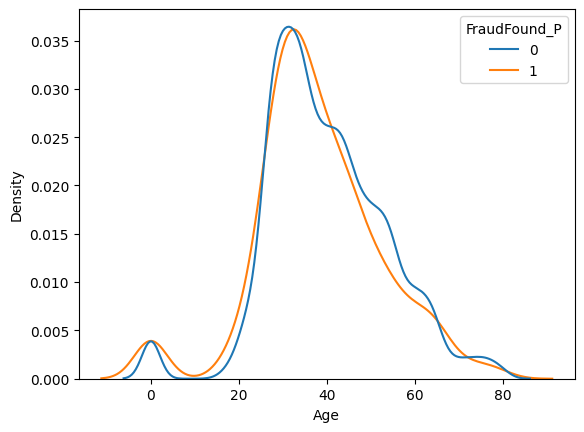

In [32]:
sns.kdeplot(df_train, x='Age', hue='FraudFound_P', common_norm=False)

Deductible distribution between fraud and non-fraud:

<Axes: xlabel='Deductible', ylabel='Density'>

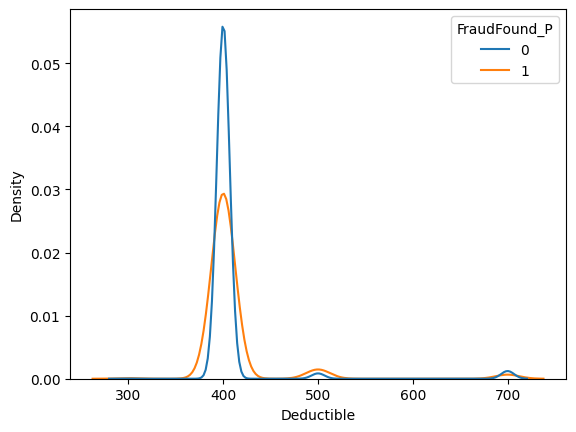

In [33]:
sns.kdeplot(df_train, x='Deductible', hue='FraudFound_P', common_norm=False)

There doesn't appear to be any relationship of the two variables above with fraud/non-fraud.

### Trends over time

<Axes: xlabel='MonthYear'>

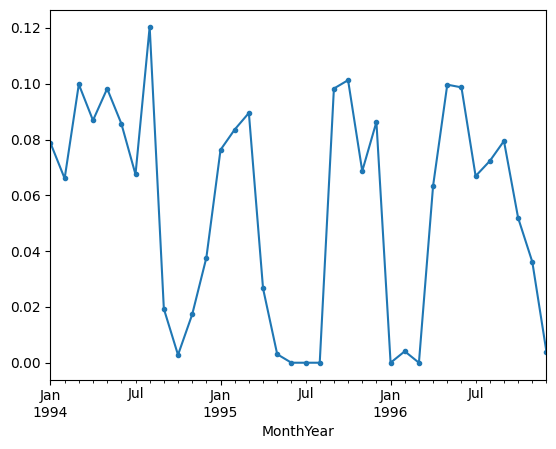

In [34]:
df_train.groupby('MonthYear')['FraudFound_P'].mean().plot.line(marker='.')

<Axes: xlabel='Year'>

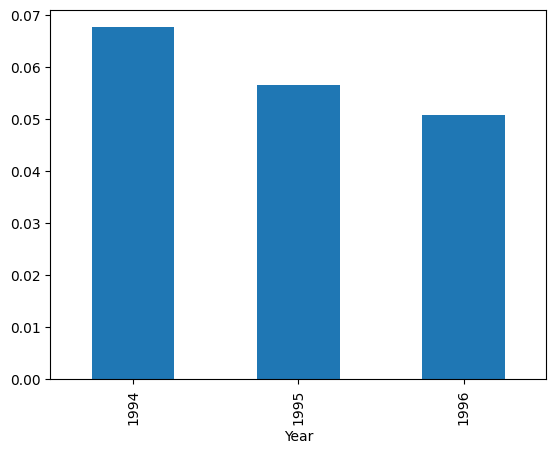

In [35]:
df_train.groupby('Year')['FraudFound_P'].mean().plot.bar()

It appears that from 1994 to 1996 the occurence of frauds are declining.

### Categorical variables

<Axes: xlabel='Density', ylabel='PolicyType'>

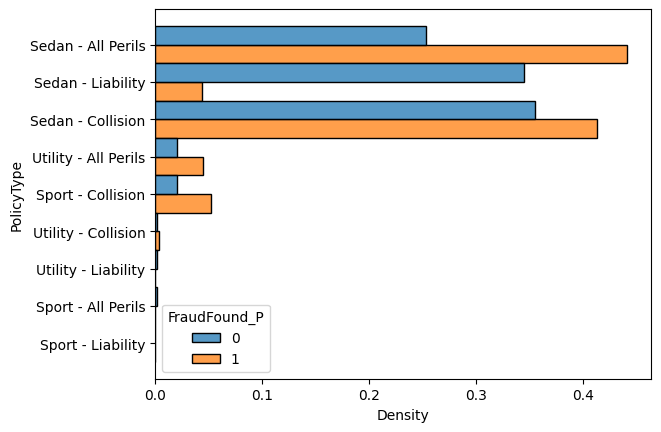

In [36]:
sns.histplot(df_train, y='PolicyType', hue='FraudFound_P', stat='density', common_norm=False, multiple='dodge')

<Axes: xlabel='Density', ylabel='VehicleCategory'>

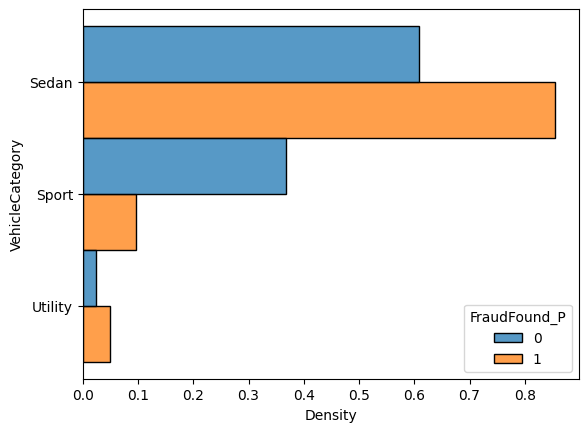

In [37]:
sns.histplot(df_train, y='VehicleCategory', hue='FraudFound_P', stat='density', common_norm=False, multiple='dodge')

<Axes: xlabel='Density', ylabel='BasePolicy'>

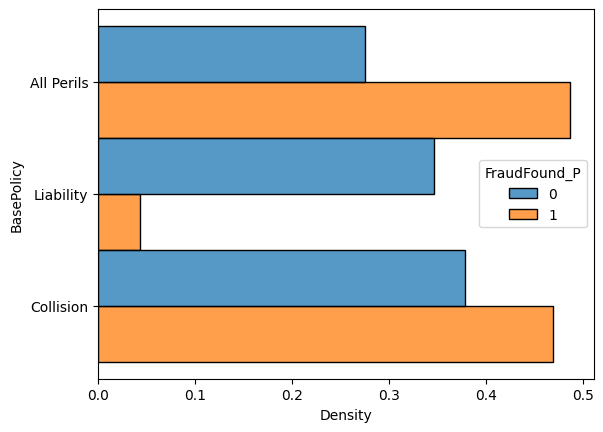

In [38]:
sns.histplot(df_train, y='BasePolicy', hue='FraudFound_P', stat='density', common_norm=False, multiple='dodge')

<Axes: xlabel='Density', ylabel='VehiclePrice'>

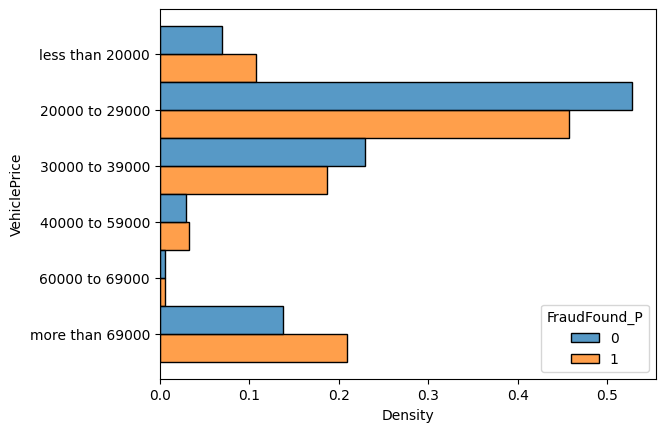

In [39]:
sns.histplot(df_train, y='VehiclePrice', hue='FraudFound_P', stat='density', common_norm=False, multiple='dodge')

<Axes: xlabel='Density', ylabel='AgeOfPolicyHolder'>

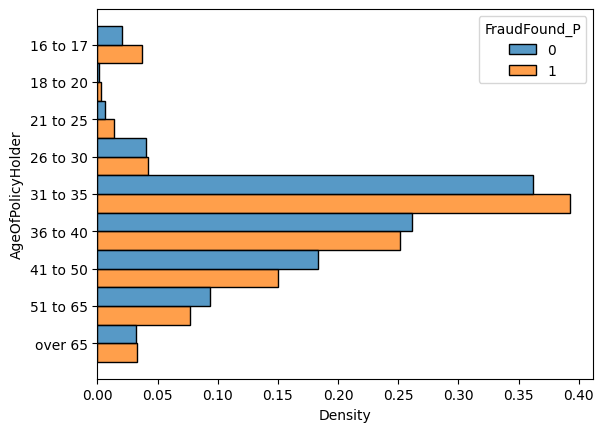

In [40]:
sns.histplot(df_train, y='AgeOfPolicyHolder', hue='FraudFound_P', stat='density', common_norm=False, multiple='dodge')

It's hard to make definite conclusion from the above visualizations. There doesn't appear to be a clear difference in the data distributions between frauds and non-frauds.

## Question 4 (calculating ExpFraudLoss)

Our goal is to determine how big is the company's loss when fraud occurs, we will examine the loss. Suppose we have some experts that can evaluate the fraudulent loss by using this formula:


```
Expected Fraudulent Loss = PolicyType Weight x Avg VehiclePrice x DriverRating Weight
```

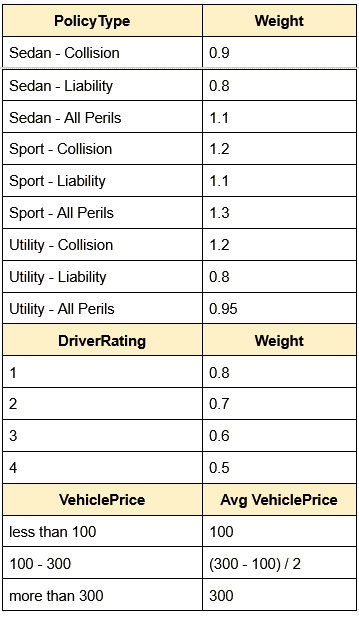

Note: I assume the formula for Avg VehiclePrice contain typo. It should be (300 + 100)/2 instead of (300-100)/2. It has been calculated previous when I calculate VehiclePrice_Num column earlier in this notebook.

In [41]:
weights_PolicyType = {
    'Sedan - Collision': 0.9,
    'Sedan - Liability': 0.8,
    'Sedan - All Perils': 1.1,
    'Sport - Collision': 1.2,
    'Sport - Liability': 1.1,
    'Sport - All Perils': 1.3,
    'Utility - Collision': 1.2,
    'Utility - Liability': 0.8,
    'Utility - All Perils': 0.95,
}

weights_DriverRating = {
    1: 0.8,
    2: 0.7,
    3: 0.6,
    4: 0.5,
}

In [42]:
for df_ in [df_train, df_valid, df_test]:
    df_['PolicyType_Weight'] = df_['PolicyType'].map(weights_PolicyType)
    df_['DriverRating_Weight'] = df_['DriverRating'].map(weights_DriverRating).astype(float)
    df_['ExpFraudLoss'] = df_['PolicyType_Weight'] * df_['DriverRating_Weight'] * df_['VehiclePrice_Num']

In [43]:
df_train[['DriverRating', 'DriverRating_Weight', 'PolicyType', 'PolicyType_Weight']]

,DriverRating,DriverRating_Weight,PolicyType,PolicyType_Weight
7542,4,0.5,Sedan - All Perils,1.1
15133,1,0.8,Sedan - Liability,0.8
4974,3,0.6,Sedan - Liability,0.8
13389,4,0.5,Sedan - All Perils,1.1
11215,3,0.6,Sedan - All Perils,1.1
...,...,...,...,...
4059,2,0.7,Sedan - Liability,0.8
1404,1,0.8,Sedan - Liability,0.8
1287,1,0.8,Sedan - Liability,0.8
12306,4,0.5,Sedan - Collision,0.9


## Question 5 (ExpFraudLoss EDA)

Perform exploratory data analysis using variable ExpFraudLoss, find the distribution, relationship with other variables, and descriptive statistics measurement on this feature. Explain the insights related to the fraudulent detection.


Distribution of ExpFraudLoss:

<Axes: xlabel='ExpFraudLoss', ylabel='Count'>

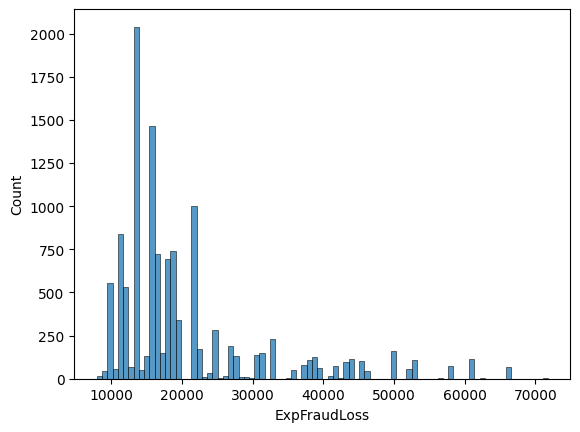

In [44]:
sns.histplot(df_train['ExpFraudLoss'])

In [45]:
df_train['ExpFraudLoss'].describe()

count    12291.000000
mean     20524.527296
std      11401.524229
min       8000.000000
25%      13475.000000
50%      16170.000000
75%      22080.000000
max      71760.000000
Name: ExpFraudLoss, dtype: float64

As you can see, the mean of ExpFraudLoss is USD 20,524, and the median is USD 16,170. It means 50% of cases have ExpFraudLess of USD 16,170 or higher.

Average ExpFraudLoss per vehicle category:

<Axes: xlabel='VehicleCategory'>

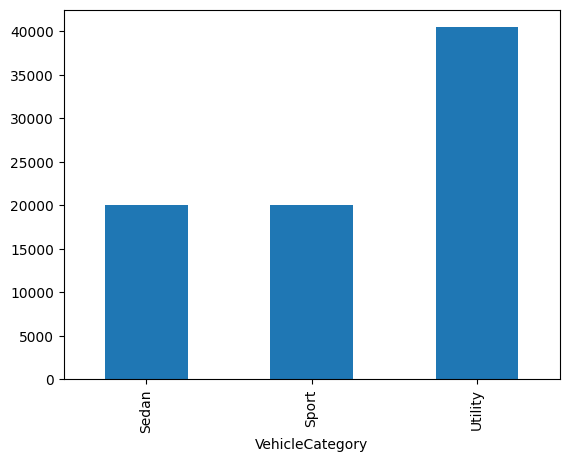

In [46]:
df_train.groupby('VehicleCategory')['ExpFraudLoss'].mean().plot.bar()

Average ExpFraudLoss per base policy:

<Axes: xlabel='BasePolicy'>

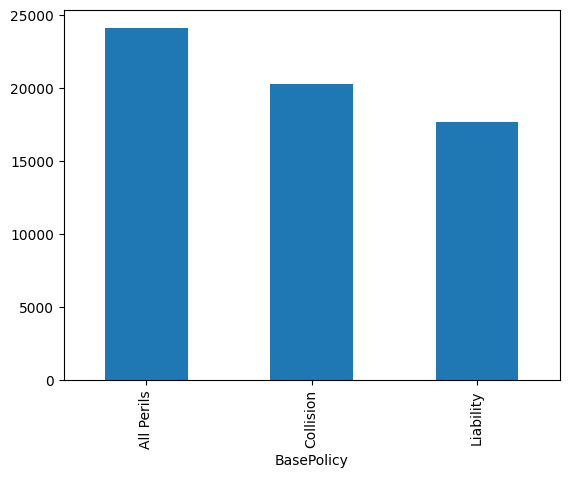

In [47]:
df_train.groupby('BasePolicy')['ExpFraudLoss'].mean().plot.bar()

<Axes: xlabel='PolicyType'>

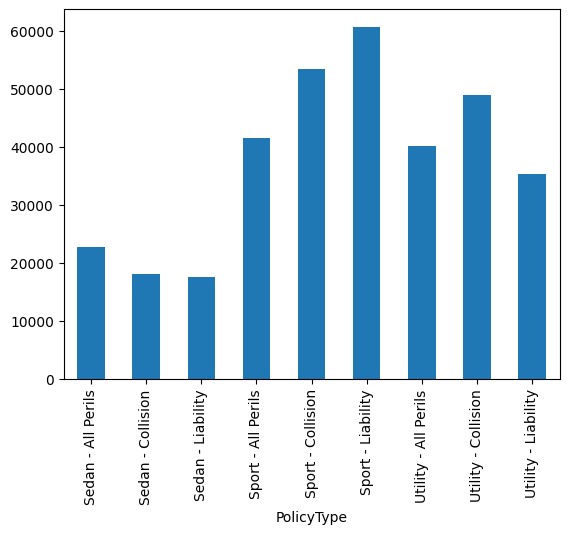

In [48]:
df_train.groupby('PolicyType')['ExpFraudLoss'].mean().plot.bar()

Average ExpFraudLoss per driver rating:

<Axes: xlabel='DriverRating'>

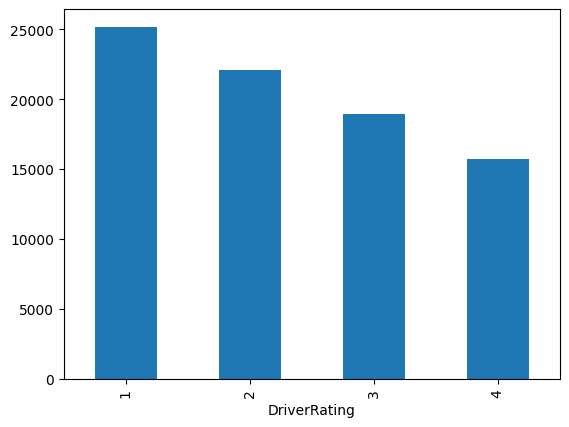

In [49]:
df_train.groupby('DriverRating', observed=True)['ExpFraudLoss'].mean().plot.bar()

ExpFraudLoss for every age:

<Axes: xlabel='Age'>

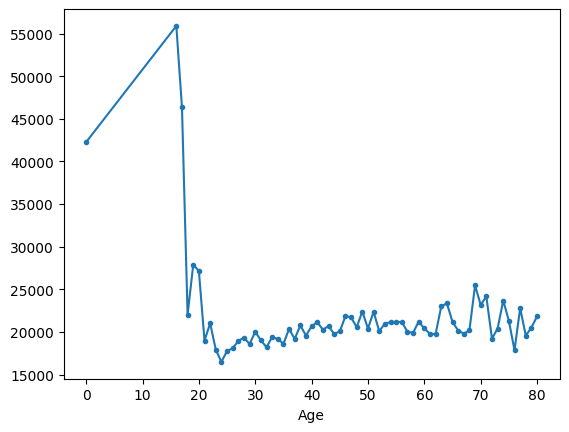

In [50]:
df_train.groupby('Age', observed=True)['ExpFraudLoss'].mean().plot.line(marker='.')

**Interesting...** Age 0, 16, 17 have very high vehicle price, causing ExpFraudLoss to spike:

In [51]:
df_train[df_train['Age'].isin((0, 16, 17))][['Age', 'VehiclePrice']].groupby('VehiclePrice', observed=True).size()

VehiclePrice
30000 to 39000       1
more than 69000    272
dtype: int64

Distribution of ExpFraudLoss between fraud and non-fraud:

<Axes: xlabel='ExpFraudLoss', ylabel='Density'>

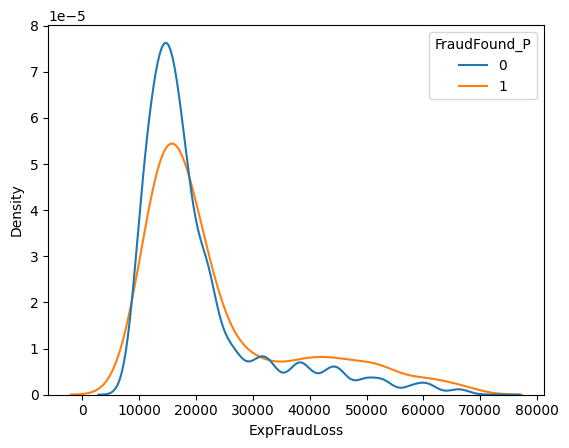

In [52]:
sns.kdeplot(df_train, x='ExpFraudLoss', hue='FraudFound_P', common_norm=False) 

It seems fraud cases have higher ExpFraudLoss.

## Question 6 (Baseline vs expert-based model)

Create 2 models, evaluate the performance of model, and simulate the cost of making false prediction

Create a baseline model and expert based model (using if-else statement based on exploration data analysis in question 3 and 5) to predict (detect) the fraudulent cases. Evaluate the baseline model using evaluation metrics and ROC/AUC. Make simulation based on this condition:

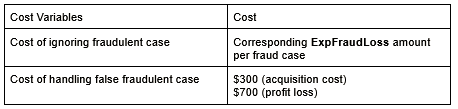

Create table summary of the evaluation

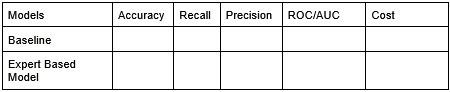

**Side note**: I notice that the cost of ignoring fraudulent cases (false negative) is disproportionately higher than the cost of rejecting non-fraudulent cases (false positive). `ExpFraudLoss` has mean of USD 20k per fraudulent claim. Meanwhile, the cost of falsely rejecting non-fraudulent cases is only USD 300 + 700 = USD 1000 per customer.

In [53]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator

In [54]:
def calc_model_cost(
    y_true: pd.Series,
    y_pred: pd.Series,
    exp_fraud_loss: pd.Series,
) -> float:
    fp = (y_pred == 1) & (y_true == 0)
    fn = (y_pred == 0) & (y_true == 1)

    # cost of accepting fraudulent claims
    fn_cost = (fn * exp_fraud_loss).sum()

    # cost of not accepting valid claims
    fp_cost = (fp * (300 + 700)).sum()
    return fp_cost + fn_cost

In [55]:
def calc_model_metrics(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> dict[str, float]:
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_prob)
    cost = calc_model_cost(y, y_pred, X['ExpFraudLoss'])
    return {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'roc_auc': roc_auc,
        'cost': cost,
    }

In [56]:
def split_Xy(df: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame, pd.Series]:
    y = df[target_col]
    X = df.drop(target_col, axis=1)
    return X, y

In [57]:
X_train, y_train = split_Xy(df_train, 'FraudFound_P')
X_valid, y_valid = split_Xy(df_valid, 'FraudFound_P')
X_test, y_test = split_Xy(df_test, 'FraudFound_P')

In [58]:
class ExpertBasedModel(BaseEstimator):
    def fit(self, X, y):
        self.is_fitted_ = True
        self.y_prior = (y == 1).mean()
        return self

    def predict(self, X):
        y_prob = self.predict_proba(X)[:, 1]
        return (y_prob > 0.5).astype(int)

    def predict_proba(self, X):
        y_prob = np.ones(len(X)) * self.y_prior
        is_fraud =\
            (X['Age'] < 18) | \
            (X['PolicyType'].isin(('Utility - All Perils', 'Utility - Collision', 'Sport - Collision'))) | \
            (X['AddressChange_Claim'].isin(('2 to 3 years', 'under 6 months'))) | \
            (X['Make'].isin(('Saturn', 'Saab', 'Accura'))) | \
            (X['AgeOfPolicyHolder'].isin(('16 to 17', '21 to 25', '18 to 20')))
        y_prob[is_fraud] = 1.0
        output = np.vstack([1 - y_prob, y_prob]).T
        return output

In [59]:
model_results = dict()

# base model of always predicting 0
base_model = DummyClassifier(strategy='prior')
base_model.fit(X_train, y_train)

model_results['base_model'] = calc_model_metrics(base_model, X_valid, y_valid)

expert_model = ExpertBasedModel()
expert_model.fit(X_train, y_train);
roc_auc_score(y_valid, expert_model.predict_proba(X_valid)[:, 1])
model_results['expert_model'] = calc_model_metrics(expert_model, X_valid, y_valid)

C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
metrics_df = pd.DataFrame(model_results).T.round(2)
metrics_df

,accuracy,recall,precision,roc_auc,cost
base_model,0.94,0.00,0.00,0.50,2044380.0
expert_model,0.83,0.26,0.11,0.57,1423170.0


How much do the expert model save vs `base_model`?

In [61]:
metrics_df['cost']['expert_model'] / metrics_df['cost']['base_model'] - 1

-0.30386229565931966

Answer: about 30%.

## Question 7 (statistical approach model)

Perform fraud detection using 2 Statistical Approach (IQR and Z-score method) using numerical variables as X. Make cost simulation just like the Question 6 point one and create a table summary of evaluation

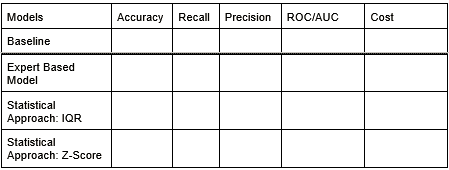

Evaluate and compare all the models, write your insights on how you will decide which model that you want to propose as the fraud detection model.


In [62]:
class ZScoreModel(BaseEstimator):
    def __init__(
        self, *,
        num_vars: list[str],
        upper_threshold: float | None = None,
        lower_threshold: float | None = None,
    ):
        self.num_vars = num_vars
        if upper_threshold is None:
            upper_threshold = 999
        if lower_threshold is None:
            lower_threshold = -999
        self.upper_threshold = upper_threshold
        self.lower_threshold = lower_threshold

    def fit(self, X, y):
        self.is_fitted_ = True
        self.y_prior = (y == 1).mean()

        self.mus = X[self.num_vars].mean()
        self.stds = X[self.num_vars].std()

        return self

    def predict(self, X):
        y_prob = self.predict_proba(X)[:, 1]
        return (y_prob > 0.5).astype(int)

    def predict_proba(self, X):
        y_prob = np.ones(len(X)) * self.y_prior
        X_num = X[self.num_vars]
        Z = (X_num - self.mus) / self.stds
        is_fraud = ((Z > self.upper_threshold) | (Z < self.lower_threshold)).any(axis=1)
        y_prob[is_fraud] = 1.0
        output = np.vstack([1 - y_prob, y_prob]).T
        return output

In [63]:
class IQRModel(BaseEstimator):
    def __init__(
        self, *,
        num_vars: list[str],
    ):
        self.num_vars = num_vars

    def fit(self, X, y):
        self.is_fitted_ = True
        self.y_prior = (y == 1).mean()

        q1 = X[num_vars].quantile(0.25)
        q3 = X[num_vars].quantile(0.75)
        iqr = q3 - q1
        self.lbound = q1 - 1.5 * iqr
        self.ubound = q3 + 1.5 * iqr
        return self

    def predict(self, X):
        y_prob = self.predict_proba(X)[:, 1]
        return (y_prob > 0.5).astype(int)

    def predict_proba(self, X):
        y_prob = np.ones(len(X)) * self.y_prior
        X_num = X[self.num_vars]
        is_fraud = ((X_num > self.ubound) | (X_num < self.lbound)).any(axis=1)
        y_prob[is_fraud] = 1.0
        output = np.vstack([1 - y_prob, y_prob]).T
        return output

In [64]:
zscore_model = ZScoreModel(num_vars=num_vars, upper_threshold=1.5)
zscore_model.fit(X_train, y_train)

model_results['zscore_model'] = calc_model_metrics(zscore_model, X_valid, y_valid)

iqr_model = IQRModel(num_vars=num_vars)
iqr_model.fit(X_train, y_train)

model_results['iqr_model'] = calc_model_metrics(iqr_model, X_valid, y_valid)

In [65]:
pd.DataFrame(model_results).T

,accuracy,recall,precision,roc_auc,cost
base_model,0.940755,0.000000,0.000000,0.500000,2044380.0
expert_model,0.832031,0.263736,0.111628,0.565778,1423170.0
zscore_model,0.671875,0.439560,0.081136,0.563033,1331890.0
iqr_model,0.709635,0.373626,0.080378,0.552211,1369500.0


Based on the ROC/AUC metric, the expert-based model is the best one compared to other models. However, if we look at the cost, the Z-Score model has the lowest cost vs other models. Based on this result, I will propose to use the Z-Score model.

## Question 8 (ROI, total utility, etc)

- You proposed a fraud detection model to minimize fraud losses. However, beyond cost savings, you must also consider benefits, model ownership costs, and fraud handling costs. ROI is calculated as the ratio of net profit (benefit minus costs) to total investment, expressed as a percentage.

```
ROI = Total Utility / (Total cost of ownership + Total cost of fraud handling)
```

- Total utility is defined as the difference between benefits and costs, representing the net return. 
    - Costs are as follows:
        - False Negatives (FN): Fraud loss, represented by the ExpFraudLoss amount for ignored fraud cases.
        - False Positives (FP): Losses from profit and customer acquisition costs, including \\$300 for acquisition and \\$700 for profit loss per false positive.
    - Benefits include: 
        - True Positives (TP): Prevented fraud losses, represented by ExpFraudLoss.
        - True Negatives (TN): Generated profit of \\$700 from legitimate transactions.
- The total cost of ownership consists of acquisition costs (\\$500,000 for software, hardware, security, and development) and operation costs (\\$500,000 for migration, setup, monitoring, and support).
- Total Cost of Fraud Handling includes inspection and legal costs. Assume:
    - Fraud handling cost per claim: Varies by vehicle category
        - Sedan: \\$6,000
        - Sport: \\$8,000
        - Utility: \\$4,000
    - Legal cost: \\$50,000

Now I will calculate the ROI for each model.

In [66]:
def calc_total_utility(y_true: pd.Series, y_pred: pd.Series, exp_fraud_loss: pd.Series) -> float:
    cost = calc_model_cost(y_true, y_pred, exp_fraud_loss)

    tp = (y_true == 1) & (y_pred == 1)
    tn = (y_true == 0) & (y_pred == 0)

    tp_benefit = (tp * exp_fraud_loss).sum()
    tn_benefit = (tn * 700).sum()

    total_benefit = tp_benefit + tn_benefit

    total_utility = total_benefit - cost
    return total_utility

In [67]:
def calc_roi(y_true: pd.Series, y_pred: pd.Series, exp_fraud_loss: pd.Series, vehicle_category: pd.Series):
    total_utility = calc_total_utility(y_true, y_pred, exp_fraud_loss)
    tco = 500e3 + 500e3 # acquisition + operation costs

    # calculate fraud handling cost for every claims we predict as frauds
    fraud_handling_cost = 50000
    vehicle_claim_cost = vehicle_category.map({'Sedan': 6000, 'Sport': 8000, 'Utility': 4000})
    total_fraud_handling_cost = (y_pred * (vehicle_claim_cost + fraud_handling_cost)).sum()

    roi = total_utility / (tco + total_fraud_handling_cost)

    return roi

In [68]:
roi_kwargs = dict(
    exp_fraud_loss=X_valid['ExpFraudLoss'],
    vehicle_category=X_valid['VehicleCategory'],
)
print('Base', calc_roi(y_valid, base_model.predict(X_valid), **roi_kwargs))
print('Expert', calc_roi(y_valid, expert_model.predict(X_valid), **roi_kwargs))
print('IQR Model', calc_roi(y_valid, iqr_model.predict(X_valid), **roi_kwargs))
print('Z-Score Model', calc_roi(y_valid, zscore_model.predict(X_valid), **roi_kwargs))

Base -1.03288
Expert 0.020295101916641314
IQR Model 0.017387712544112928
Z-Score Model 0.018273690039454556


From the result above, the expert-based model results in the highest ROI at 2.03%. The 2nd best model is the IQR one with ROI equal to 1.74%.